In [ ]:
# Elimino todas las variables en el entorno de trabajo
rm(list = ls())

**PARTE 2**

**APRENDIZAJE SUPERVISADO – CLASIFICACIÓN**

Modelos de clasificación, determinación de clases estimadas y evaluación de resultados.

Conjunto de datos: “METROPOLITANA_2016.csv”.

La Encuesta Mundial sobre Tabaco en Jóvenes (GYTS, por sus siglas en inglés) es un estándar global para el monitoreo sistemático del consumo de tabaco (fumado y sin humo) en los jóvenes y de los indicadores clave de control del tabaco. La GYTS forma parte del Sistema Mundial de Vigilancia del Tabaquismo (GTSS, por su sigla en inglés), el mayor sistema mundial de vigilancia de la salud pública jamás desarrollado y mantenido. El archivo “METROPOLITANA_2016.csv” contiene información sobre el hábito de fumar de casi 2.800 jóvenes de la Región Metropolitana.


In [67]:
# cargo librerias
library(readr)
library(MASS)
library(ggplot2)
library(dplyr)
library(VIM)
library(mice)
library(caret)
library(naivebayes)
library(rsample)
library(pROC)
library(glmnet)

1.	Importe la base de datos y guárdela en un data frame llamado “gytsAux”. 

In [2]:
gytsAux <- as.data.frame(read.csv("METROPOLITANA_2016.csv"))

2.	Recuerde que el tipo de datos de las variables  al realizar la importación podría no coincidir con la definición real de los tipos de datos. Para determinar los tipos de datos reales debe analizar la información complementaria sobre la encuesta. Una vez que haya corregido los tipos de datos (si es que es necesario), describa estadísticamente y de forma concisa cada una de las variables que componen el data frame, indicando también si corresponden a variables numéricas o categóricas. Mantenga solamente las 8 variables de mayor interés para usted justificadamente. En su justificación mencione aspectos teóricos y técnicos. Mantenga estas 8 variables en un data frame nuevo llamado “gyts”.

De acuerdo a la información contenida en el pdf `"GYTSPAHO2016 Chile All Schools Region 4 (Metropolitana) Web Codebook.pdf`" procedo a convertir las columnas a sus tipos adecuados. 

In [3]:
# Identifico todas las columnas excepto FinalWgt y PSU
cols_a_factor <- setdiff(names(gytsAux), c("FinalWgt", "PSU"))

# Convierto todas las columnas identificadas a factor
gytsAux[cols_a_factor] <- lapply(gytsAux[cols_a_factor], as.factor)

In [4]:
# Convierto FinalWgt y PSU a numérico
gytsAux$FinalWgt <- as.numeric(gytsAux$FinalWgt)
gytsAux$PSU <- as.numeric(gytsAux$PSU)

Compruebo que todas las columnas estan consideradas en el dataframe con el tipo correcto de dato:

In [5]:
str(gytsAux)

'data.frame':	2778 obs. of  75 variables:
 $ FinalWgt: num  177 177 177 177 177 ...
 $ CR1     : Factor w/ 7 levels "1","2","3","4",..: 5 5 5 5 5 5 5 6 6 6 ...
 $ CR2     : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ CLR3    : Factor w/ 6 levels "1","2","3","4",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ CLR4    : Factor w/ 7 levels "1","2","3","4",..: 1 1 1 2 4 4 4 3 3 3 ...
 $ CR5     : Factor w/ 2 levels "1","2": 1 2 2 2 1 1 1 1 1 2 ...
 $ CR6     : Factor w/ 7 levels "1","2","3","4",..: 6 1 1 1 4 4 6 3 5 1 ...
 $ CR7     : Factor w/ 7 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CR8     : Factor w/ 7 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ CR9     : Factor w/ 2 levels "1","2": 2 2 2 2 1 2 2 2 1 2 ...
 $ CR10    : Factor w/ 2 levels "1","2": 2 2 2 2 1 2 2 2 2 2 ...
 $ CR11    : Factor w/ 4 levels "1","2","3","4": 2 1 1 1 1 2 2 2 2 1 ...
 $ CR12    : Factor w/ 8 levels "1","2","3","4",..: 2 1 1 1 1 2 1 2 1 1 ...
 $ CR13    : Factor w/ 2 levels "1","2": 2 2 2 2 2 

Justificacion Técnica de la elección de las 8 variables

In [6]:
# Elimino filas con valores faltantes
gytsAux_sin_na <- na.omit(gytsAux)

# Ajusto un modelo inicial
modelo_inicial <- lm(FinalWgt ~ ., data = gytsAux_sin_na)

In [7]:
# Capturo el output del proceso de stepwise en una variable, pero sin imprimirlo
# demora alrededor de 2 minutos
step_output <- capture.output({
  modelo_step_AIC <- step(modelo_inicial, direction = "both", k = 2)
})

# Imprimo solo la últimas 81 lineas del proceso
# que corresponden a la última iteración
# que es la que nos interesa
cat(tail(step_output, 81), sep = "\n")

Step:  AIC=12970.79
FinalWgt ~ CR1 + CR2 + CLR3 + CR10 + OR9 + CLR27 + CR22 + CR23 + 
    CR25 + CLR38 + CLR40 + CLR42 + CLR49 + CR37 + OR55 + OR46 + 
    Stratum + PSU

          Df Sum of Sq     RSS   AIC
<none>                 1597239 12971
+ CR34     2      3339 1593900 12971
+ CR17     3      4972 1592267 12971
+ CR42     2      2903 1594336 12971
- CLR49    5      8863 1606102 12971
+ CR38     1       748 1596491 12972
+ CLR34    1       722 1596517 12972
+ CR30     1       704 1596535 12972
+ CR41     3      3947 1593292 12972
+ CR5      1       572 1596667 12972
+ CLR28    1       507 1596732 12972
+ CLR47    2      2166 1595073 12972
+ CR32     2      2029 1595210 12972
+ CR13     1       183 1597056 12973
+ CR24     1       126 1597113 12973
+ CR9      1        92 1597147 12973
+ CR14     1        15 1597224 12973
+ OR45     4      5022 1592217 12973
+ CLR16    4      4931 1592308 12973
+ CLR39    5      6598 1590641 12973
+ CLR72    2      1416 1595823 12973
+ CR12     7    

In [8]:
# Capturo el output del proceso de stepwise con BIC en una variable,
# pero solo guardandolo
# demora alrededor de 2 minutos
step_output_BIC <- capture.output({
  modelo_step_BIC <- step(modelo_inicial, direction = "both",
                          k = log(nrow(gytsAux)))
})

# Imprimo solo la últimas 79 lineas del proceso
# que corresponden a la última iteración
# que es la que nos interesa
cat(tail(step_output_BIC, 79), sep = "\n")

Step:  AIC=13148.82
FinalWgt ~ CR2 + CLR3 + CR22 + Stratum + PSU

          Df Sum of Sq     RSS   AIC
<none>                 1727363 13149
+ CR25     1      3189 1724174 13153
+ CR10     1      3179 1724184 13153
+ OR55     1      2857 1724506 13154
+ CR37     1      2019 1725344 13154
+ CR38     1      1516 1725848 13155
+ CLR40    2      8362 1719001 13155
+ CR9      1       980 1726383 13156
+ CR5      1       588 1726775 13156
+ CLR28    1       217 1727146 13156
+ CR30     1       164 1727199 13157
+ CR24     1       109 1727254 13157
+ CLR34    1       108 1727256 13157
+ CR13     1         2 1727361 13157
+ CR14     1         0 1727363 13157
+ OR46     3     12436 1714927 13159
+ CR34     2      4524 1722839 13160
+ CLR47    2      3496 1723867 13161
+ CR42     2      2602 1724761 13162
+ CLR70    2      2371 1724992 13162
+ CR23     3      9044 1718319 13163
+ CR31     2      1642 1725721 13163
+ CR32     2      1318 1726045 13163
+ CLR48    2      1314 1726049 13163
+ CLR33  

Nota importante: aunque se muestra como "AIC", el valor reportado es realmente el BIC, ya que estoy utilizando `k = log(nrow(gytsAux))` para penalizar los modelos. Y esto es porque la función `step()` en R está diseñada para mostrar el AIC en su salida, incluso cuando estoy utilizando BIC como criterio de selección.

**Análisis del Stepwise Regression con AIC**

En el último paso de la selección con AIC, las siguientes variables fueron retenidas:
- CR1, CR2, CLR3, CLR4, CR10, CR11, CR12, OR9, CLR17, OR13, CR17, CR18, CLR27, CR22, CR23, CR25, CLR38, CLR39, CLR40, CLR41, CLR42, CR32, CLR49, CR38, CR41, CR42, CLR65, OR46 y PSU.

**Análisis del Stepwise Regression con BIC**

En el último paso de la selección con BIC, las siguientes variables fueron retenidas:
- CR2, CLR3, CR22, CLR41 y PSU.

**Justificación de la Selección de Variables mediante criterio tecnico**

- AIC vs. BIC: El criterio AIC tiende a seleccionar un mayor número de variables porque penaliza menos la complejidad del modelo. BIC, en cambio, penaliza más la complejidad y selecciona un modelo más parsimonioso (con menos variables).

- Variables Comunes: Al observar las variables seleccionadas por ambos criterios, noto que CR2, CLR3, CR22, CLR41, y PSU son comunes en ambos. Por ende, estas variables son altamente relevantes para el modelo y por eso son parte en la selección final, con la excepcion de PSU que no está definida que significa en el PDF `"GYTSPAHO2016 Chile All Schools Region 4 (Metropolitana) Web Codebook.pdf"` ni en la pagina web https://extranet.who.int/ncdsmicrodata/index.php/catalog/387/data-dictionary/F3?file_name=METROPOLITANA_2016

Hasta ahora, he seleccionado las variables explicativas **CR2, CLR3, CR22 y CLR41** mediante análisis técnico. Sin embargo, me faltan elegir cuatro variables adicionales. Dado que en la siguiente etapa de Machine Learning se indica que CR7 será la variable objetivo ("Durante los últimos 30 días, ¿en cuántos días fumaste cigarrillos?"), analizaré cuidadosamente cuáles serán las otras cuatro variables que elegiré, considerando su potencial para predecir CR7 de manera efectiva.

Justificación analisis teorico

CR19 - Smoked inside home in your presence:

- Considero que la exposición al humo de segunda mano en casa es un predictor significativo de la aceptación y normalización del hábito de fumar. Esto indica que la exposición al humo en casa puede influir en la percepción y la aceptación del comportamiento de fumar, lo que hace que esta variable sea un componente crucial en el modelo.

CR17 - Stop smoking if wanted to:

- La percepción de la capacidad para dejar de fumar refleja la motivación y la autoeficacia del individuo para abandonar el hábito. 
- La capacidad percibida para dejar de fumar (capturada por CR17) está estrechamente relacionada con estas motivaciones internas y, por lo tanto, es un predictor importante del comportamiento de fumar.

CR20 - Smoked inside public place in your presence past 7 days:

- Similar a la exposición en el hogar, la exposición al humo en lugares públicos refleja la normalización social del fumar, lo que puede influir en el comportamiento del encuestado. Osea que la exposición al humo en lugares públicos puede influir en la percepción y aceptación social del fumar, haciendo de esta variable un importante predictor.

OR46 - Closest friends smoke:

- Se justifica por el impacto significativo que las influencias sociales, especialmente las de los amigos cercanos, tienen en el comportamiento de fumar. Esta variable captura la dinámica del grupo social inmediato del encuestado, que es un factor crucial en la adopción y persistencia del hábito de fumar.

Por ende de acuerdo al analisis tecnico y teorico las 8 variables seleccionadas son:

**CR2, CLR3, CR22, CLR41, CR19, CR17, CR20, y OR46**

Y de acuerdo al correo respondido el día 17/08/2024 con copia a todo el curso por parte del profesor, procedo a describir estadisticamente y de forma concisa sólo las 8 variables que justificadamente elegí.

In [9]:
# genero variable con las columnas seleccionadas
# que son todas categoricas
gyts <- as.data.frame(gytsAux[, c("CR2", "CLR3", "CR22", "CLR41", "CR19", "CR17", "CR20", "OR46")])

summary(gyts)

   CR2         CLR3       CR22       CLR41        CR19        CR17     
 1   :1278   1   :517   1   :1509   1   :1136   1   :1653   1   :1589  
 2   :1480   2   :547   2   :1201   2   : 591   2   : 348   2   : 464  
 NA's:  20   3   :543   NA's:  68   3   : 996   3   : 201   3   : 650  
             4   :462               NA's:  55   4   : 108   4   :  42  
             5   :336                           5   : 442   NA's:  33  
             6   :358                           NA's:  26              
             NA's: 15                                                  
   CR20        OR46     
 1   :1397   1   : 746  
 2   : 594   2   :1279  
 3   : 273   3   : 579  
 4   : 135   4   :  86  
 5   : 352   NA's:  88  
 NA's:  27              
                        

In [10]:
# Calculo los porcentajes por clase para cada columna categórica
porcentajes_por_clase <- lapply(gyts, function(col) {
  prop.table(table(col))
})

# Muestra los porcentajes por clase
porcentajes_por_clase

$CR2
col
        1         2 
0.4633793 0.5366207 

$CLR3
col
        1         2         3         4         5         6 
0.1871155 0.1979732 0.1965255 0.1672096 0.1216069 0.1295693 

$CR22
col
        1         2 
0.5568266 0.4431734 

$CLR41
col
        1         2         3 
0.4171869 0.2170400 0.3657730 

$CR19
col
         1          2          3          4          5 
0.60065407 0.12645349 0.07303779 0.03924419 0.16061047 

$CR17
col
         1          2          3          4 
0.57887067 0.16903461 0.23679417 0.01530055 

$CR20
col
         1          2          3          4          5 
0.50781534 0.21592148 0.09923664 0.04907306 0.12795347 

$OR46
col
         1          2          3          4 
0.27732342 0.47546468 0.21524164 0.03197026 


In [11]:
#todos los posibles valores para cada variable categórica
#en español
valores_categoria <- list(
  CR2 = c("1" = "Hombre", "2" = "Mujer"),
  CLR3 = c("1" = "7° básico",
           "2" = "8° básico",
           "3" = "1° medio",
           "4" = "2° medio",
           "5" = "3° medio",
           "6" = "4° medio"),
  CR22 = c("1" = "Sí", "2" = "No"),
  CLR41 = c("1" = "Sí", "2" = "No", "3" = "No lo sé"),
  CR19 = c("1" = "0 días", "2" = "1 a 2 días", "3" = "3 a 4 días",
           "4" = "5 a 6 días", "5" = "7 días"),
  CR17 = c("1" = "Nunca he fumado",
           "2" = "No fumo ahora",
           "3" = "Sí",
           "4" = "No"),
  CR20 = c("1" = "0 días", "2" = "1 a 2 días", "3" = "3 a 4 días",
           "4" = "5 a 6 días", "5" = "7 días"),
  OR46 = c("1" = "Ninguno de ellos",
           "2" = "Algunos de ellos",
           "3" = "La mayoría de ellos",
           "4" = "Todos ellos")
)

In [12]:
# Defino los significados de las variables en español
significados_variables <- list(
  CR2 = "Sexo",
  CLR3 = "Nivel de educación",
  CR22 = "Visto fumar en la escuela",
  CLR41 = "Posibilidad de comprar cigarrillos sueltos",
  CR19 = "Fumaron en casa en su presencia",
  CR17 = "Dejar de fumar si lo desea",
  CR20 = "Fumaron en lugar público en su presencia",
  OR46 = "Amigos cercanos que fuman"
)

In [13]:
# Función para describir estadísticamente una variable
# con su significado
describir_variable <- function(var_name) {
  var <- gytsAux[[var_name]]
  n_unique <- length(unique(var))
  moda <- names(sort(table(var), decreasing = TRUE))[1]
  moda_significado <- valores_categoria[[var_name]][moda]
  significado_var <- significados_variables[[var_name]]

  # Determino el tipo de variable
  tipo_var <- ifelse(class(var) == "factor", "categórica", 
                     ifelse(class(var) == "numeric", "númerica", class(var)))

  cat(sprintf("Descripción de la variable: %s (%s)\n",
              var_name, significado_var))
  cat(sprintf("Tipo de variable: %s\n", tipo_var))
  cat(sprintf("Número de categorías únicas: %d\n", n_unique))
  # Solo muestro la moda y su significado si es categórica
  if (tipo_var == "categórica") {
    cat(sprintf("Moda (valor más frecuente): %s (%s)\n",
                moda, moda_significado))
  }
  cat("\n")  # Agrego línea en blanco para separar las descripciones
}

# Aplico la función a cada variable de interés
gyts <- c("CR2", "CLR3", "CR22", "CLR41", "CR19", "CR17", "CR20", "OR46")

for (col in gyts) {
  describir_variable(col)
}

Descripción de la variable: CR2 (Sexo)
Tipo de variable: categórica
Número de categorías únicas: 3
Moda (valor más frecuente): 2 (Mujer)

Descripción de la variable: CLR3 (Nivel de educación)
Tipo de variable: categórica
Número de categorías únicas: 7
Moda (valor más frecuente): 2 (8° básico)

Descripción de la variable: CR22 (Visto fumar en la escuela)
Tipo de variable: categórica
Número de categorías únicas: 3
Moda (valor más frecuente): 1 (Sí)

Descripción de la variable: CLR41 (Posibilidad de comprar cigarrillos sueltos)
Tipo de variable: categórica
Número de categorías únicas: 4
Moda (valor más frecuente): 1 (Sí)

Descripción de la variable: CR19 (Fumaron en casa en su presencia)
Tipo de variable: categórica
Número de categorías únicas: 6
Moda (valor más frecuente): 1 (0 días)

Descripción de la variable: CR17 (Dejar de fumar si lo desea)
Tipo de variable: categórica
Número de categorías únicas: 5
Moda (valor más frecuente): 1 (Nunca he fumado)

Descripción de la variable: CR20 (F

3. Realice estadística descriptiva con mayor detalle principalmente sobre la variable “Q7 (CR7)…”. Se espera que cruce dicha variable con otras 4-5 de interés. Incorpore análisis gráfico. 

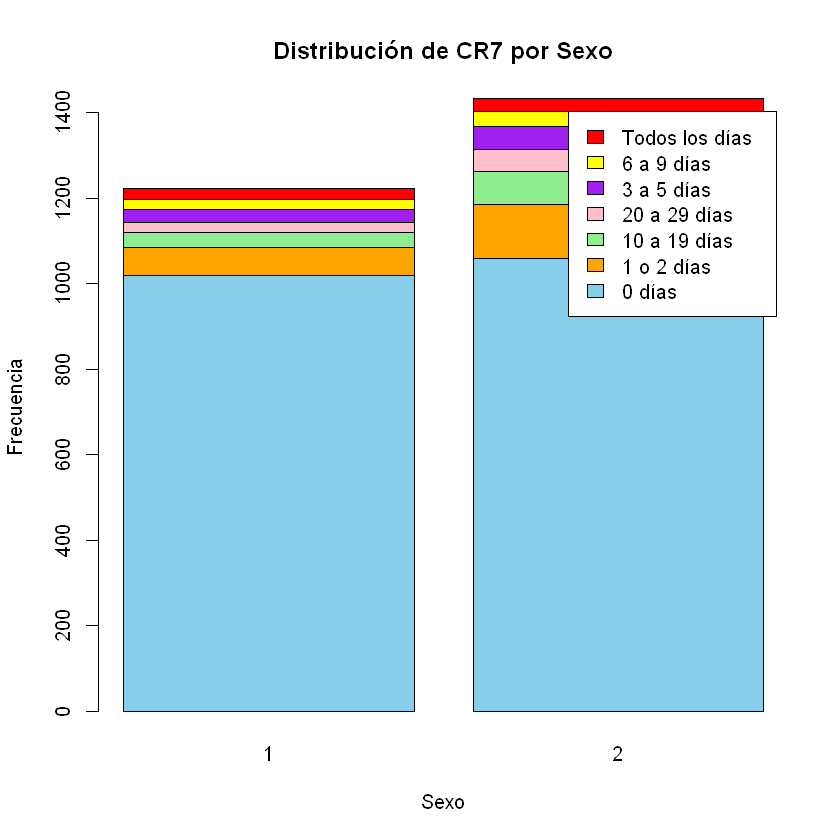

In [14]:
# Gráfico de barras apiladas para CR7 y CR2 (Sexo)
barplot(table(gytsAux$CR7, gytsAux$CR2),
        legend.text = c("0 días", "1 o 2 días", "10 a 19 días", "20 a 29 días",
                        "3 a 5 días", "6 a 9 días", "Todos los días"),
        col = c("skyblue", "orange", "lightgreen", "pink",
                "purple", "yellow", "red"),
        main = "Distribución de CR7 por Sexo",
        xlab = "Sexo",
        ylab = "Frecuencia",
        beside = FALSE)

CR2 (Sexo):

- 1 = Hombre
- 2 = Mujer

CR7 (Días fumados en los últimos 30 días):

- 1 = 0 días
- 2 = 1 o 2 días
- 3 = 10 a 19 días
- 4 = 20 a 29 días
- 5 = 3 a 5 días
- 6 = 6 a 9 días
- 7 = Todos los días

La mayoría de los encuestados, tanto hombres como mujeres, no han fumado en los últimos 30 días (0 días).

Tambien se observa que tanto en hombres como en mujeres, el mayor porcentaje de individuos no ha fumado en los últimos 30 días. Sin embargo, hay una ligera tendencia a que las mujeres presenten una menor frecuencia en las categorías de consumo más alto (3 a 5 días, 6 a 9 días, todos los días) en comparación con los hombres.

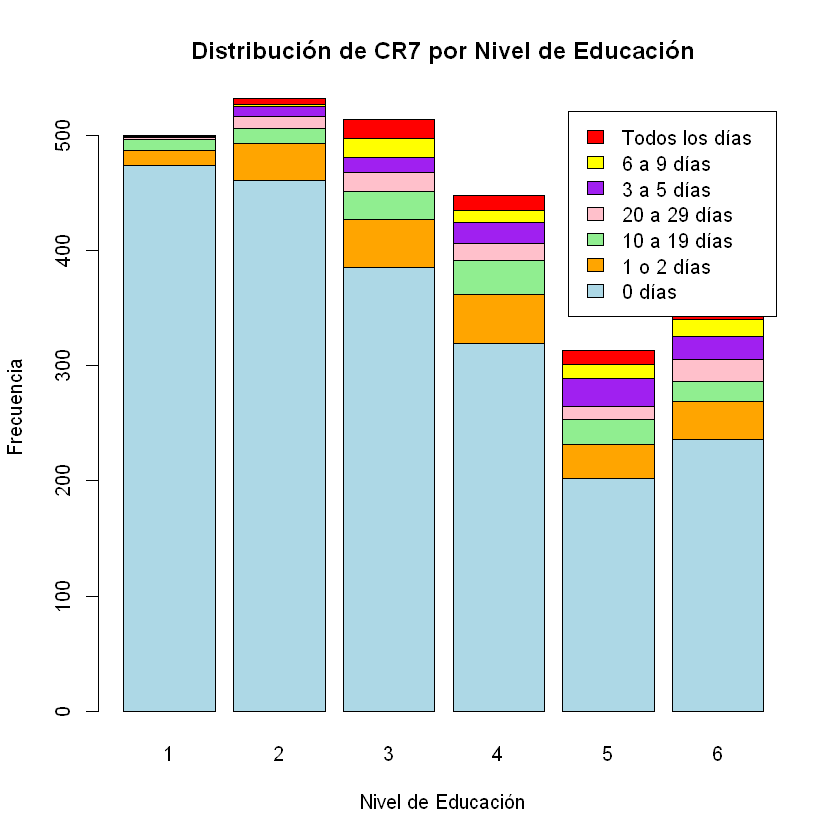

In [15]:
# Gráfico de barras apiladas para CR7 y CLR3 (Nivel de educación)
barplot(table(gytsAux$CR7, gytsAux$CLR3),
        legend.text = c("0 días", "1 o 2 días", "10 a 19 días", "20 a 29 días",
                        "3 a 5 días", "6 a 9 días", "Todos los días"),
        col = c("lightblue", "orange", "lightgreen", "pink",
                "purple", "yellow", "red"),
        main = "Distribución de CR7 por Nivel de Educación",
        xlab = "Nivel de Educación",
        ylab = "Frecuencia",
        beside = FALSE)

CLR3 (Nivel de educación):

- 1 = 7° básico
- 2 = 8° básico
- 3 = 1° medio
- 4 = 2° medio
- 5 = 3° medio
- 6 = 4° medio

CR7 (Días fumados en los últimos 30 días):

- 1 = 0 días
- 2 = 1 o 2 días
- 3 = 10 a 19 días
- 4 = 20 a 29 días
- 5 = 3 a 5 días
- 6 = 6 a 9 días
- 7 = Todos los días

Se observa en el gráfico que los estudiantes de niveles más bajos de educación (7° y 8° básico) muestran un mayor porcentaje de no fumadores (0 días). Sin embargo, conforme aumenta el nivel educativo, hay una ligera disminución en la proporción de no fumadores y un aumento en aquellos que han fumado entre 1 a 9 días o más en los últimos 30 días.

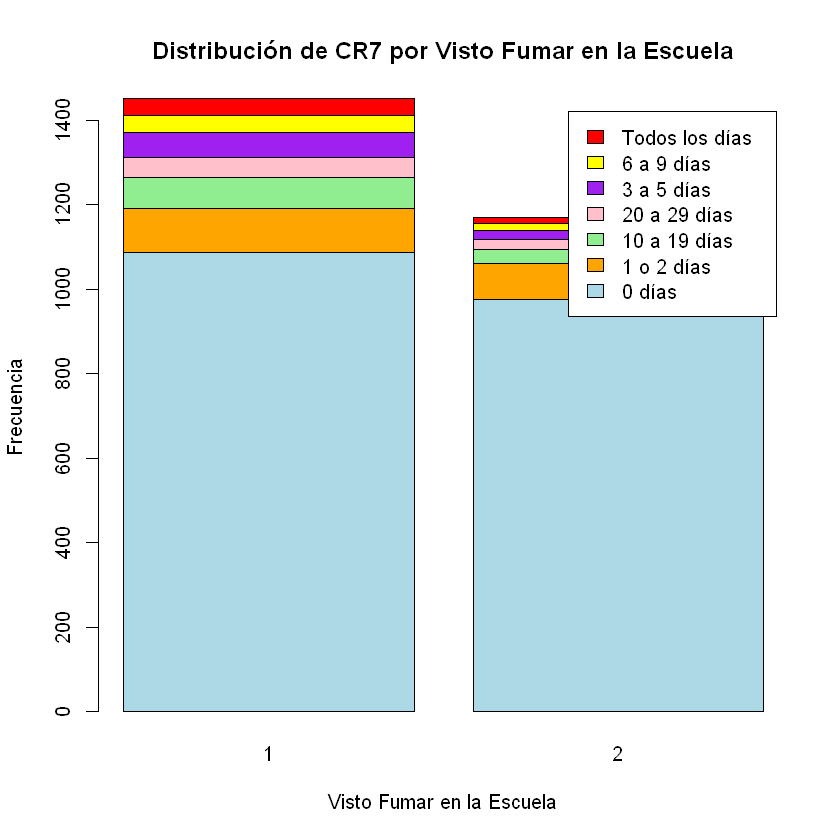

In [16]:
# Gráfico de barras apiladas para CR7 y CR22 (Visto fumar en la escuela)
barplot(table(gytsAux$CR7, gytsAux$CR22),
        legend.text = c("0 días", "1 o 2 días", "10 a 19 días",
                        "20 a 29 días", "3 a 5 días", "6 a 9 días",
                        "Todos los días"),
        col = c("lightblue", "orange", "lightgreen", "pink",
                "purple", "yellow", "red"),
        main = "Distribución de CR7 por Visto Fumar en la Escuela",
        xlab = "Visto Fumar en la Escuela",
        ylab = "Frecuencia",
        beside = FALSE)

CR22 (Visto fumar en la escuela):

- 1 = Sí
- 2 = No

CR7 (Días fumados en los últimos 30 días):

- 1 = 0 días
- 2 = 1 o 2 días
- 3 = 10 a 19 días
- 4 = 20 a 29 días
- 5 = 3 a 5 días
- 6 = 6 a 9 días
- 7 = Todos los días

Se ve graficamente que aquellos que han visto fumar en la escuela tienen una mayor tendencia a haber fumado en los últimos 30 días, comparado con aquellos que no lo han visto. Esta relación sugiere que la exposición al comportamiento de fumar en el entorno escolar podría influir en la decisión de fumar de los estudiantes.

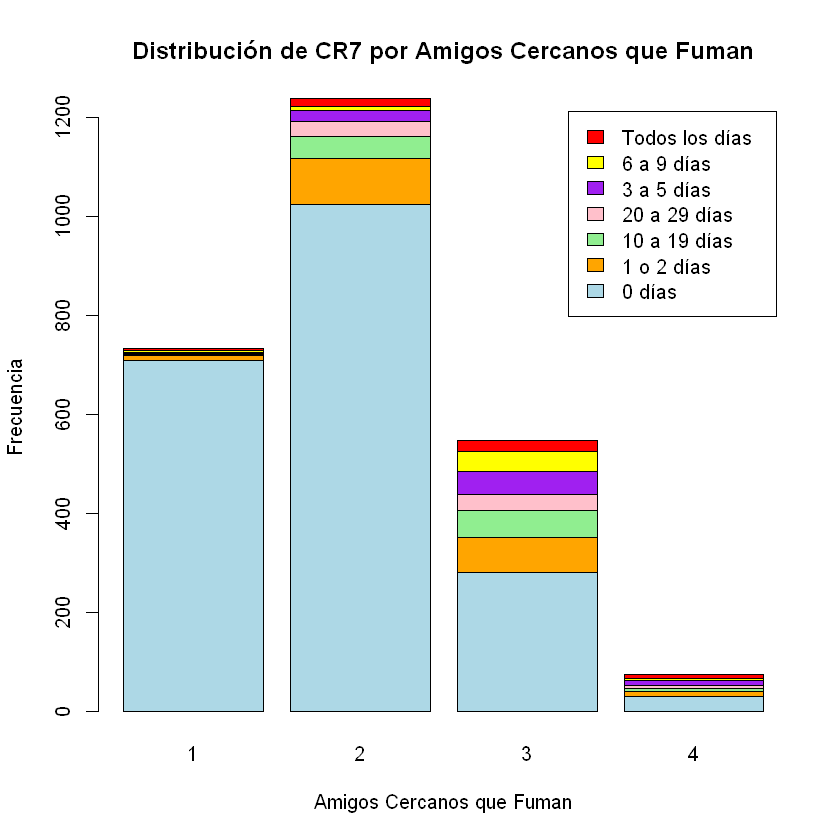

In [17]:
# Gráfico de barras apiladas para CR7 y OR46 (Amigos cercanos que fuman)
barplot(table(gytsAux$CR7, gytsAux$OR46),
        legend.text = c("0 días", "1 o 2 días", "10 a 19 días",
                        "20 a 29 días", "3 a 5 días", "6 a 9 días",
                        "Todos los días"),
        col = c("lightblue", "orange", "lightgreen", "pink",
                "purple", "yellow", "red"),
        main = "Distribución de CR7 por Amigos Cercanos que Fuman",
        xlab = "Amigos Cercanos que Fuman",
        ylab = "Frecuencia",
        beside = FALSE)

OR46 (Amigos cercanos que fuman):

- 1 = Ninguno de ellos
- 2 = Algunos de ellos
- 3 = La mayoría de ellos
- 4 = Todos ellos

CR7 (Días fumados en los últimos 30 días):

- 1 = 0 días
- 2 = 1 o 2 días
- 3 = 10 a 19 días
- 4 = 20 a 29 días
- 5 = 3 a 5 días
- 6 = 6 a 9 días
- 7 = Todos los días

Veo en el gráfico que los estudiantes cuyos amigos cercanos no fuman (Ninguno de ellos) son en su mayoría no fumadores. Sin embargo, a medida que aumenta el número de amigos que fuman (especialmente "Todos ellos"), también aumenta la probabilidad de que el estudiante haya fumado en los últimos 30 días, destacando la fuerte influencia social en el comportamiento de fumar.

Analisis estadístico descriptivo sobre la variable “Q7 (CR7)…”. Y cruces de dicha variable con otras 4-5 de interés.

In [18]:
# Defino los posibles valores para las variables CR7 y CR2
valores_CR7 <- c("1" = "0 días", "2" = "1 o 2 días", "3" = "10 a 19 días",
                 "4" = "20 a 29 días", "5" = "3 a 5 días", "6" = "6 a 9 días",
                 "7" = "Todos los días")

valores_CR2 <- c("1" = "Hombre", "2" = "Mujer")

# Creo tabla de contingencia con nombres
tabla_CR7_CR2 <- table(factor(gytsAux$CR7, labels = valores_CR7),
                       factor(gytsAux$CR2, labels = valores_CR2))
# Imprimo tabla de contingencia
print(tabla_CR7_CR2)

                
                 Hombre Mujer
  0 días           1019  1058
  1 o 2 días         65   127
  10 a 19 días       35    78
  20 a 29 días       23    51
  3 a 5 días         32    54
  6 a 9 días         22    35
  Todos los días     27    30


Asociación entre CR7 (Días fumados en los últimos 30 días) y CR2 (Sexo):

- La mayoría de los encuestados, tanto hombres como mujeres, no han fumado en los últimos 30 días ("0 días").
- Sin embargo, se observa una tendencia en la que hay más mujeres que hombres que reportan haber fumado "1 o 2 días" y "10 a 19 días".
- A medida que aumenta la frecuencia de fumar (más días fumados), las diferencias entre sexos se reducen.

Esto sugiere que mientras la mayoría de ambos sexos no fuman, hay una proporción ligeramente mayor de mujeres que hombres en las categorías de fumadores ocasionales. Esto podría reflejar diferencias en los patrones de iniciación o en la exposición al tabaco entre sexos.

In [19]:
valores_CLR3 <- c("1" = "7° básico", "2" = "8° básico", "3" = "1° medio",
                  "4" = "2° medio", "5" = "3° medio", "6" = "4° medio")

# Tabla de contingencia entre CR7 y CLR3 (Nivel de educación)
tabla_CR7_CLR3 <- table(factor(gytsAux$CR7, labels = valores_CR7), 
                        factor(gytsAux$CLR3, labels = valores_CLR3))
print(tabla_CR7_CLR3)

                
                 7° básico 8° básico 1° medio 2° medio 3° medio 4° medio
  0 días               474       461      385      319      202      236
  1 o 2 días            13        32       42       43       30       33
  10 a 19 días           9        13       24       29       21       17
  20 a 29 días           2        10       17       15       12       19
  3 a 5 días             1         9       13       18       24       20
  6 a 9 días             1         2       16       11       12       15
  Todos los días         0         5       17       13       12       10


Asociación entre CR7 (Días fumados en los últimos 30 días) y CLR3 (Nivel de educación):

- Los estudiantes de 7° y 8° básico tienen una mayor proporción de no fumadores en comparación con los de niveles superiores.
- A medida que el nivel de educación aumenta, parece haber un incremento en el número de días fumados, especialmente en las categorías "3 a 5 días" y "Todos los días".

La relación entre el nivel educativo y el comportamiento de fumar puede estar influenciada por varios factores, como la exposición al tabaco y la presión de pares en niveles educativos superiores. El hecho de que los estudiantes en niveles más avanzados tengan una mayor prevalencia de días fumados podría indicar que el riesgo de fumar aumenta con la edad o el acceso a cigarrillos.

In [20]:
valores_CR22 <- c("1" = "Sí", "2" = "No")

# Tabla de contingencia entre CR7 y CR22 (Visto fumar en la escuela)
tabla_CR7_CR22 <- table(factor(gytsAux$CR7, labels = valores_CR7), 
                        factor(gytsAux$CR22, labels = valores_CR22))
print(tabla_CR7_CR22)

                
                   Sí   No
  0 días         1088  976
  1 o 2 días      103   84
  10 a 19 días     74   35
  20 a 29 días     48   22
  3 a 5 días       58   23
  6 a 9 días       40   16
  Todos los días   41   13


Asociación entre CR7 (Días fumados en los últimos 30 días) y CR22 (Visto fumar en la escuela):

- Aquellos que han visto a otros fumar en la escuela tienden a reportar más días fumados en los últimos 30 días.
- La proporción de encuestados que no han fumado ("0 días") es menor entre aquellos que han visto fumar en la escuela en comparación con aquellos que no lo han visto.

La exposición a compañeros fumando en la escuela parece correlacionarse con una mayor propensión a fumar. Esto resalta la importancia del entorno escolar en la influencia sobre el comportamiento de los adolescentes respecto al tabaquismo.

In [21]:
valores_OR46 <- c("1" = "Ninguno de ellos", "2" = "Algunos de ellos",
                  "3" = "La mayoría de ellos", "4" = "Todos ellos")

# Tabla de contingencia entre CR7 y OR46 (Amigos cercanos que fuman)
tabla_CR7_OR46 <- table(factor(gytsAux$CR7, labels = valores_CR7), 
                        factor(gytsAux$OR46, labels = valores_OR46))
print(tabla_CR7_OR46)

                
                 Ninguno de ellos Algunos de ellos La mayoría de ellos
  0 días                      708             1024                 280
  1 o 2 días                   10               93                  71
  10 a 19 días                  2               44                  55
  20 a 29 días                  2               31                  32
  3 a 5 días                    2               22                  47
  6 a 9 días                    5                8                  40
  Todos los días                3               16                  23
                
                 Todos ellos
  0 días                  31
  1 o 2 días              10
  10 a 19 días             6
  20 a 29 días             6
  3 a 5 días              10
  6 a 9 días               3
  Todos los días           9


Asociación entre CR7 (Días fumados en los últimos 30 días) y OR46 (Amigos cercanos que fuman):

- Una gran proporción de no fumadores ("0 días") tiene pocos o ningún amigo que fuma.
- A medida que el número de amigos fumadores aumenta, también lo hace la cantidad de días que el encuestado reporta haber fumado, especialmente en las categorías de fumadores más frecuentes ("10 a 19 días", "20 a 29 días", "Todos los días").

La influencia de los amigos cercanos es claramente un factor importante en el comportamiento de fumar. Los datos muestran que tener más amigos que fuman se asocia con un mayor número de días fumados, lo que subraya la importancia de los vinculos sociales en la adopción y mantenimiento del hábito de fumar.

Analisis de asociacion con Chi-cuadrado

In [22]:
# Test Chi-cuadrado entre CR7 y CR2 (Sexo)
chisq_test_CR7_CR2 <- chisq.test(gytsAux$CR7, gytsAux$CR2)
cat("Resultado del Test Chi-cuadrado entre CR7 y CR2 (Sexo):\n")
print(chisq_test_CR7_CR2)
cat("\n")

# Test Chi-cuadrado entre CR7 y CLR3 (Nivel de educación)
chisq_test_CR7_CLR3 <- chisq.test(gytsAux$CR7, gytsAux$CLR3)
cat("Resultado del Test Chi-cuadrado entre CR7 y CLR3 (Nivel de educación):\n")
print(chisq_test_CR7_CLR3)
cat("\n")

# Test Chi-cuadrado entre CR7 y CR22 (Visto fumar en la escuela)
chisq_test_CR7_CR22 <- chisq.test(gytsAux$CR7, gytsAux$CR22)
cat("Resultado del Test Chi-cuadrado entre CR7 y CR22 (Visto fumar en la escuela):\n")
print(chisq_test_CR7_CR22)
cat("\n")

# Test Chi-cuadrado entre CR7 y OR46 (Amigos cercanos que fuman)
chisq_test_CR7_OR46 <- chisq.test(gytsAux$CR7, gytsAux$OR46)
cat("Resultado del Test Chi-cuadrado entre CR7 y OR46 (Amigos cercanos que fuman):\n")
print(chisq_test_CR7_OR46)
cat("\n")

Resultado del Test Chi-cuadrado entre CR7 y CR2 (Sexo):

	Pearson's Chi-squared test

data:  gytsAux$CR7 and gytsAux$CR2
X-squared = 40.108, df = 6, p-value = 4.338e-07


Resultado del Test Chi-cuadrado entre CR7 y CLR3 (Nivel de educación):

	Pearson's Chi-squared test

data:  gytsAux$CR7 and gytsAux$CLR3
X-squared = 207.48, df = 30, p-value < 2.2e-16


Resultado del Test Chi-cuadrado entre CR7 y CR22 (Visto fumar en la escuela):

	Pearson's Chi-squared test

data:  gytsAux$CR7 and gytsAux$CR22
X-squared = 41.474, df = 6, p-value = 2.335e-07




Warning message in chisq.test(gytsAux$CR7, gytsAux$OR46):
"Chi-squared approximation may be incorrect"


Resultado del Test Chi-cuadrado entre CR7 y OR46 (Amigos cercanos que fuman):

	Pearson's Chi-squared test

data:  gytsAux$CR7 and gytsAux$OR46
X-squared = 539.82, df = 18, p-value < 2.2e-16




1. Asociación entre CR7 (Días fumados en los últimos 30 días) y CR2 (Sexo):

- Estadístico Chi-cuadrado (X-squared): 40.108
- Grados de libertad (df): 6
- p-valor: 4.338e-07

El p-valor es extremadamente pequeño (mucho menor que 0.05), lo que indica que hay una relación significativa entre la cantidad de días que los encuestados han fumado en los últimos 30 días y su sexo. Esto sugiere que el comportamiento de fumar podría diferir entre hombres y mujeres, lo que coincide con la literatura que a menudo señala diferencias de género en el hábito de fumar.

2. Asociación entre CR7 (Días fumados en los últimos 30 días) y CLR3 (Nivel de educación):

- Estadístico Chi-cuadrado (X-squared): 207.48
- Grados de libertad (df): 30
- p-valor: < 2.2e-16

El p-valor es nuevamente extremadamente pequeño, indicando una fuerte relación entre la cantidad de días que los encuestados han fumado y su nivel de educación. Este resultado sugiere que el nivel de educación puede influir en la frecuencia de fumar, probablemente debido a la influencia de la educación en la percepción de los riesgos para la salud y el acceso a información sobre los peligros del tabaco.

3. Asociación entre CR7 (Días fumados en los últimos 30 días) y CR22 (Visto fumar en la escuela):

- Estadístico Chi-cuadrado (X-squared): 41.474
- Grados de libertad (df): 6
- p-valor: 2.335e-07

El p-valor indica una relación significativa entre la cantidad de días que los encuestados han fumado en los últimos 30 días y si han visto a otros fumar en la escuela. Esto sugiere que la exposición al comportamiento de fumar en un entorno escolar puede estar asociada con una mayor probabilidad de que los estudiantes fumen, lo que es coherente con teorías sobre el modelado de comportamiento y la influencia de pares.

4. Asociación entre CR7 (Días fumados en los últimos 30 días) y OR46 (Amigos cercanos que fuman):

- Estadístico Chi-cuadrado (X-squared): 539.82
- Grados de libertad (df): 18
- p-valor: < 2.2e-16

El p-valor extremadamente pequeño indica una relación muy fuerte entre la cantidad de días que los encuestados han fumado en los últimos 30 días y si sus amigos cercanos fuman. Esto respalda la idea de que la presión de grupo y las normas sociales dentro de los círculos de amigos son factores clave en la adopción del hábito de fumar.

La advertencia sobre la aproximación incorrecta del Chi-cuadrado sugiere que podría haber celdas en la tabla de contingencia con frecuencias esperadas muy bajas. Esto podría afectar la validez del test de Chi-cuadrado, sugiriendo que los resultados deben interpretarse con cautela.

`En los próximos apartados debe analizar un problema de aprendizaje supervisado de clasificación mediante una regresión logística y el algoritmo Naive Bayes. Considere como variable objetivo una transformación binaria de la variable “Q7 (CR7) During the past 30 days, on how many days did you smoke cigarettes?” (vea el archivo “GYTSPAHO2016 Chile All Schools Region 4 (Metropolitana) Web Codebook.pdf”).
En R realice una copia independiente de la data para cada modelo, llámelas “gytsRL” y “gytsNB” para la regresión logística y Naive Bayes correspondientemente. Para el desarrollo del informe realizar el procedimiento completo para una técnica y luego continuar con la siguiente:`

4.	Elimine las 110 observaciones con valores perdidos en la variable “Q7 (CR7)…” Transforme la variable categórica “Q7 (CR7) During the past 30 days, on how many days did you smoke cigarettes?” en una variable binaria de valor 1 cuando el/la joven muestre signos de ser fumador/a y 0 en otro caso. Comente. 

In [23]:
# Vuelvo a cargar los datos originales y sin modificaciones
gytsAux <- as.data.frame(read.csv("METROPOLITANA_2016.csv"))

In [24]:
# Creo copias independientes de la base de datos
gytsRL <- gytsAux
gytsNB <- gytsAux

In [25]:
# Verifico la cantidad de valores faltantes por columna
cat("Número de filas originales:", nrow(gytsRL), "\n")
cat("Número de valores faltantes por columna:\n")
print(colSums(is.na(gytsRL)))

# Imprimo número de filas con al menos un valor faltante
num_filas_faltantes <- sum(rowSums(is.na(gytsRL)) > 0)
cat("Número de filas con al menos un valor faltante:", num_filas_faltantes, "\n")

Número de filas originales: 2778 
Número de valores faltantes por columna:
FinalWgt      CR1      CR2     CLR3     CLR4      CR5      CR6      CR7 
       0        2       20       15       22       55       53      110 
     CR8      CR9     CR10     CR11     CR12     CR13     CR14      OR9 
     107       78       59       25       26       58       69       38 
   CLR16    CLR17     ELR2     CR15     CR16     OR12     OR13     CR17 
      30       34       23       22       19       48       18       33 
    CR18     CR19     CR20    CLR27    CLR28     CR21     CR22     CR23 
      32       26       27       40       64       34       68       33 
    CR24    CLR33    CLR34     CR25    CLR36     CR27    CLR38    CLR39 
      78       44       57       55       51       54       40       36 
   CLR40    CLR41    CLR42     CR30     CR31     CR32    CLR46    CLR47 
      42       55       35       79       48       81       45       53 
   CLR48    CLR49     CR34     CR35     CR36     

In [26]:
# Elimino las observaciones con valores faltantes en la variable CR7
gytsRL <- gytsRL[!is.na(gytsRL$CR7), ]
gytsNB <- gytsNB[!is.na(gytsNB$CR7), ]

Considerando lo siguiente:

CR7 (Días fumados en los últimos 30 días)

- 1 = 0 días
- 2 = 1 o 2 días
- 3 = 10 a 19 días
- 4 = 20 a 29 días
- 5 = 3 a 5 días
- 6 = 6 a 9 días
- 7 = Todos los días

creo una nueva variable llamada `CR7_bin` en ambos dataframes (`gytsRL` y `gytsNB`). La variable `CR7_bin` tomará el valor de 1 si el individuo mostró signos de ser fumador (es decir, si `CR7` tiene alguno de los valores del 2 al 7) y 0 en caso contrario (cuando `CR7` es igual a 1, lo que representa 0 días fumados).

In [27]:
# Transformo CR7 en una variable binaria
gytsRL$CR7_bin <- ifelse(gytsRL$CR7 %in% 2:7, 1, 0)
gytsNB$CR7_bin <- ifelse(gytsNB$CR7 %in% 2:7, 1, 0)

# Elimino la variable CR7
# dado que CR7_bin es una transformación de CR7
# y no se necesita tener ambas variables
gytsRL$CR7 <- NULL
gytsNB$CR7 <- NULL

Modelo Naive Bayes

5.	**(Naive Bayes)**  Realice el tratamiento necesario a las variables que utilizará finalmente en función del algoritmo. Puede crear otras variables si lo desea. Explique.

Como vimos anteriormente de un total de 2778 filas, hay 870 filas con almenos 1 valor faltante por lo que simplemente borrar esas filas no es algo factible dado que son demasiadas las filas que habrian que borrar, por lo que se procederá a realizar un proceso de imputacion MICE, para así tener 0 valores missing.

In [28]:
# Selecciono variables para la imputación
# (excluyendo FinalWgt, Stratum, PSU y CR7_bin)
vars_imput <- names(gytsNB)[!names(gytsNB) %in%
                               c("FinalWgt", "Stratum", "PSU", "CR7_bin")]

In [29]:
# Especifico el método de imputación
methods <- make.method(gytsNB)
# Uso 'pmm' para todas las variables a imputar
methods[vars_imput] <- "pmm"

In [30]:
# Realizo la imputación MICE
# toma alrededor de 12 minutos
set.seed(12345)
imp <- mice(gytsNB[, vars_imput], m = 5, maxit = 50,
            method = methods[vars_imput], seed = 12345)


 iter imp variable
  1   1  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  CR14  OR9  CLR16  CLR17  ELR2  CR15  CR16  OR12  OR13  CR17  CR18  CR19  CR20  CLR27  CLR28  CR21  CR22  CR23  CR24  CLR33  CLR34  CR25  CLR36  CR27  CLR38  CLR39  CLR40  CLR41  CLR42  CR30  CR31  CR32  CLR46  CLR47  CLR48  CLR49  CR34  CR35  CR36  CR37  CR38  OR45  CR39  CR40  CR41  CR42  CR43  OR55  CLR62  CLR63  CLR64  CLR65  OR46  OR54  CLR68  CLR69  CLR70  CLR71  CLR72
  1   2  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  CR14  OR9  CLR16  CLR17  ELR2  CR15  CR16  OR12  OR13  CR17  CR18  CR19  CR20  CLR27  CLR28  CR21  CR22  CR23  CR24  CLR33  CLR34  CR25  CLR36  CR27  CLR38  CLR39  CLR40  CLR41  CLR42  CR30  CR31  CR32  CLR46  CLR47  CLR48  CLR49  CR34  CR35  CR36  CR37  CR38  OR45  CR39  CR40  CR41  CR42  CR43  OR55  CLR62  CLR63  CLR64  CLR65  OR46  OR54  CLR68  CLR69  CLR70  CLR71  CLR72
  1   3  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  C

In [31]:
# Extraigo el conjunto de datos imputado completo
gytsNB_imput <- complete(imp, 1)

# Añado las columnas que no se imputaron
gytsNB_imput$FinalWgt <- gytsNB$FinalWgt
gytsNB_imput$Stratum <- gytsNB$Stratum
gytsNB_imput$PSU <- gytsNB$PSU
gytsNB_imput$CR7_bin <- gytsNB$CR7_bin

# Verifico que no haya valores NA en el conjunto imputado
cat("Número de valores faltantes después de la imputación:\n")
print(colSums(is.na(gytsNB_imput)))

Número de valores faltantes después de la imputación:
     CR1      CR2     CLR3     CLR4      CR5      CR6      CR8      CR9 
       0        0        0        0        0        0        0        0 
    CR10     CR11     CR12     CR13     CR14      OR9    CLR16    CLR17 
       0        0        0        0        0        0        0        0 
    ELR2     CR15     CR16     OR12     OR13     CR17     CR18     CR19 
       0        0        0        0        0        0        0        0 
    CR20    CLR27    CLR28     CR21     CR22     CR23     CR24    CLR33 
       0        0        0        0        0        0        0        0 
   CLR34     CR25    CLR36     CR27    CLR38    CLR39    CLR40    CLR41 
       0        0        0        0        0        0        0        0 
   CLR42     CR30     CR31     CR32    CLR46    CLR47    CLR48    CLR49 
       0        0        0        0        0        0        0        0 
    CR34     CR35     CR36     CR37     CR38     OR45     CR39     CR4

In [32]:
# Función para crear dummies n-1 para cada columna categórica
crear_dummies <- function(df, cols) {
  for (col in cols) {
    # Identifico los niveles de la variable
    niveles <- sort(unique(df[[col]]))

    # Itero sobre los niveles menos uno
    for (nivel in niveles[-length(niveles)]) {
      nombre_columna <- paste0(col, "_", nivel)
      df[[nombre_columna]] <- as.integer(df[[col]] == nivel)
    }

    # Elimino la columna original categórica
    df[[col]] <- NULL
  }

  return(df)
}

In [33]:
# Lista de columnas categóricas que convertiré en variables dummy
cols_categoricas <- c("Stratum", "CR1", "CR2", "CLR3", "CLR4", "CR5", "CR6",
                      "CR8", "CR9", "CR10", "CR11", "CR12", "CR13", "CR14",
                      "OR9", "CLR16", "CLR17", "ELR2", "CR15", "CR16",
                      "OR12", "OR13", "CR17", "CR18", "CR19", "CR20",
                      "CLR27", "CLR28", "CR21", "CR22", "CR23", "CR24",
                      "CLR33", "CLR34", "CR25", "CLR36", "CR27", "CLR38",
                      "CLR39", "CLR40", "CLR41", "CLR42", "CR30", "CR31",
                      "CR32", "CLR46", "CLR47", "CLR48", "CLR49", "CR34",
                      "CR35", "CR36", "CR37", "CR38", "OR45", "CR39",
                      "CR40", "CR41", "CR42", "CR43", "OR55", "CLR62",
                      "CLR63", "CLR64", "CLR65", "OR46", "OR54", "CLR68",
                      "CLR69", "CLR70", "CLR71", "CLR72")

In [34]:
# Aplico la función a la base de datos
gytsNB_imput <- crear_dummies(gytsNB_imput, cols_categoricas)

In [35]:
# Verifico que no haya valores NA después de crear dummies
print(colSums(is.na(gytsNB_imput)))

         FinalWgt               PSU           CR7_bin Stratum_201604001 
                0                 0                 0                 0 
Stratum_201604002 Stratum_201604003 Stratum_201604004 Stratum_201604005 
                0                 0                 0                 0 
Stratum_201604006 Stratum_201604007 Stratum_201604008 Stratum_201604009 
                0                 0                 0                 0 
Stratum_201604010 Stratum_201604011             CR1_1             CR1_2 
                0                 0                 0                 0 
            CR1_3             CR1_4             CR1_5             CR1_6 
                0                 0                 0                 0 
            CR2_1            CLR3_1            CLR3_2            CLR3_3 
                0                 0                 0                 0 
           CLR3_4            CLR3_5            CLR4_1            CLR4_2 
                0                 0                

In [36]:
# Muestro las dimensiones del nuevo dataframe
print(dim(gytsNB_imput))

[1] 2668  238


In [37]:
# Muestro los nombres de las columnas
print(names(gytsNB_imput))

  [1] "FinalWgt"          "PSU"               "CR7_bin"          
  [4] "Stratum_201604001" "Stratum_201604002" "Stratum_201604003"
  [7] "Stratum_201604004" "Stratum_201604005" "Stratum_201604006"
 [10] "Stratum_201604007" "Stratum_201604008" "Stratum_201604009"
 [13] "Stratum_201604010" "Stratum_201604011" "CR1_1"            
 [16] "CR1_2"             "CR1_3"             "CR1_4"            
 [19] "CR1_5"             "CR1_6"             "CR2_1"            
 [22] "CLR3_1"            "CLR3_2"            "CLR3_3"           
 [25] "CLR3_4"            "CLR3_5"            "CLR4_1"           
 [28] "CLR4_2"            "CLR4_3"            "CLR4_4"           
 [31] "CLR4_5"            "CLR4_6"            "CR5_1"            
 [34] "CR6_1"             "CR6_2"             "CR6_3"            
 [37] "CR6_4"             "CR6_5"             "CR6_6"            
 [40] "CR8_1"             "CR8_2"             "CR8_3"            
 [43] "CR8_4"             "CR8_5"             "CR8_6"            
 [46] "CR9

¿Por qué consideré agregar a Stratum dentro del modelo de Machine learning pero no a PSU ni FinalWgt?

- **PSU (Primary Sampling Unit)**: PSU es una variable utilizada para controlar la estructura de la muestra y ajustar los errores estándar en análisis estadísticos. Por ende en contexto de machine learning no será útil porque no aporta directamente a la predicción, sino que es más relevante en el contexto del diseño de la encuesta.

- **FinalWgt (Final Weight)**: Es un peso de encuesta diseñado para ajustar las estimaciones para que sean representativas de la población general. No se utiliza como predictor en modelos de machine learning, sino más bien para ajustar las estimaciones agregadas a nivel de población. Si incluyera esta variable en el modelo podría sesgar los resultados en mi modelo, ya que los modelos de machine learning ya buscan patrones en los datos sin requerir este tipo de ponderación.

- **Stratum**: La variable Stratum puede ser relevante si los estratos capturan variaciones significativas en la población que pueden influir en el comportamiento que estás modelando (por ejemplo, si diferentes estratos demográficos o geográficos tienen comportamientos muy distintos en relación a la variable objetivo, lo que podría ser razonable considerando la desigualdad socioeconomica que existe en santiago).

In [38]:
# Por ende procedo a eliminar las columnas que no aportan información
# PSU y FinalWgt
gytsNB_imput$PSU <- NULL
gytsNB_imput$FinalWgt <- NULL

In [39]:
# Transformo las variables dummy y la variable objetivo a factores
gytsNB_imput <- gytsNB_imput %>%
  mutate(across(where(is.integer), as.factor))

# me aseguro de que la variable objetivo es un factor
gytsNB_imput$CR7_bin <- as.factor(gytsNB_imput$CR7_bin)

# Verificación final de la estructura del dataset
str(gytsNB_imput)

'data.frame':	2668 obs. of  236 variables:
 $ CR7_bin          : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604001: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Stratum_201604002: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604003: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604004: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604005: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604006: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604007: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604008: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604009: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604010: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604011: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ CR1_1            : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1

Evaluacion del modelo Naive Bayes mediante ROC, teniendo como output un vector de probabilidades

6.	**(Naive Bayes)** Inserte una semilla. Divida la base de datos en los conjuntos de entrenamiento y prueba. Verifique que la variable objetivo cumpla el supuesto de proporción en cada conjunto. 

In [40]:
# Inserto semilla para reproducibilidad
set.seed(12345)

# Divido el conjunto de datos en entrenamiento (70%) y prueba (30%)
split <- initial_split(gytsNB_imput, prop = 0.7, strata = "CR7_bin")
gytsNB_train <- training(split)
gytsNB_test <- testing(split)

In [41]:
# Verificación de la proporción de la variable objetivo en los conjuntos
cat("Proporción de la variable objetivo en el conjunto de entrenamiento:\n")
print(round(prop.table(table(gytsNB_train$CR7_bin)), 2))

cat("Proporción de la variable objetivo en el conjunto de prueba:\n")
print(round(prop.table(table(gytsNB_test$CR7_bin)), 2))

Proporción de la variable objetivo en el conjunto de entrenamiento:

   0    1 
0.78 0.22 
Proporción de la variable objetivo en el conjunto de prueba:

   0    1 
0.78 0.22 


Se realizó la verificación de la proporción de la variable objetivo CR7_bin, que indica si un individuo mostró signos de ser fumador en los últimos 30 días (1 para fumador, 0 para no fumador). Este paso es crucial para asegurarse de que las proporciones en los conjuntos de entrenamiento y prueba reflejen adecuadamente la distribución de la población original, lo que garantiza que los modelos entrenados y evaluados sean representativos.

Resultados:

Conjunto de Entrenamiento:
- No fumador (X0): 78%
- Fumador (X1): 22%

Conjunto de Prueba:
- No fumador (X0): 78%
- Fumador (X1): 22%

Estos resultados muestran que el 78% de las observaciones en ambos conjuntos representan individuos que no fumaron en los últimos 30 días (X0), mientras que el 22% representan a aquellos que sí lo hicieron (X1). La coincidencia exacta en la proporción entre los conjuntos de entrenamiento y prueba (0.78 para X0 y 0.22 para X1) indica que ambos conjuntos son representativos de la distribución original de la variable objetivo en la base de datos completa.

Esta representatividad es fundamental para garantizar que el modelo Naive Bayes que se entrene en este conjunto de datos tenga una generalización adecuada cuando se evalúe en el conjunto de prueba, y que los resultados obtenidos puedan aplicarse a nuevos datos con una distribución similar.

7.	**(Naive Bayes)** Prediga la variable objetivo del conjunto de prueba y muestre los resultados de la curva ROC. Reporte cuál es el punto de corte que seleccionó para transformar las probabilidades estimadas en clases estimadas y fundamente. Muestre la matriz de confusión final e interprete.

In [42]:
# Me aseguro de que los niveles de CR7_bin sean nombres válidos en R
gytsNB_train$CR7_bin <- make.names(as.factor(gytsNB_train$CR7_bin))
gytsNB_test$CR7_bin <- make.names(as.factor(gytsNB_test$CR7_bin))

In [43]:
# Estrategia de remuestreo con cross-validation k-fold (5) enfocada en ROC
cv <- trainControl(method = "cv", number = 5, classProbs = TRUE,
                   summaryFunction = twoClassSummary)

# grilla de hiperparámetros
hyper_grid <- expand.grid(
  laplace = c(0, 1),
  usekernel = c(TRUE, FALSE),
  adjust = seq(0.5, 3, by = 0.5)
)

Naive Bayes 

1867 samples
 235 predictor
   2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1494, 1493, 1494, 1494, 1493 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  ROC        Sens       Spec     
  0        FALSE      0.5     0.9692618  0.9253425  0.9582656
  0        FALSE      1.0     0.9692618  0.9253425  0.9582656
  0        FALSE      1.5     0.9692618  0.9253425  0.9582656
  0        FALSE      2.0     0.9692618  0.9253425  0.9582656
  0        FALSE      2.5     0.9692618  0.9253425  0.9582656
  0        FALSE      3.0     0.9692618  0.9253425  0.9582656
  0         TRUE      0.5     0.7196589  1.0000000  0.0000000
  0         TRUE      1.0     0.7147550  1.0000000  0.0000000
  0         TRUE      1.5     0.7135101  1.0000000  0.0000000
  0         TRUE      2.0     0.6667439  1.0000000  0.0000000
  0         TRUE      2.5     0.6458857  1.0000000  0.0000000
  0         TRUE      3.0     

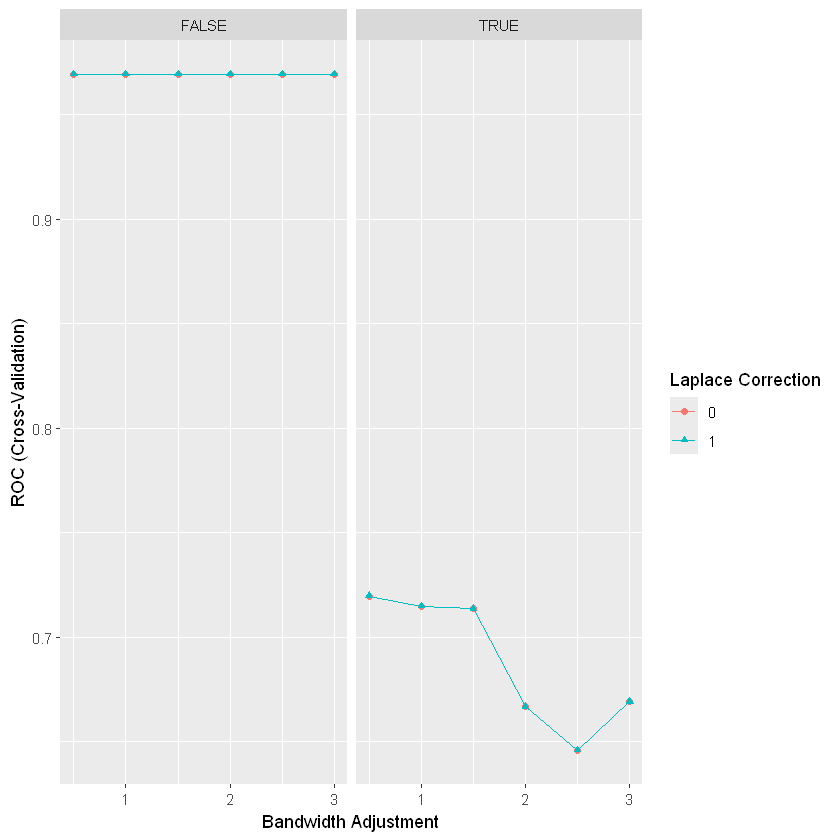

In [44]:
# Entrenamiento del modelo Naive Bayes optimizado para ROC
set.seed(12345)
naive_bayes_fit_roc <- train(
  CR7_bin ~ .,
  data = gytsNB_train,
  method = "naive_bayes",
  metric = "ROC",
  trControl = cv,
  tuneGrid = hyper_grid
)

# Muestro los resultados del modelo
print(naive_bayes_fit_roc)
ggplot(naive_bayes_fit_roc)

In [45]:
# Entrenamiento del Mejor Modelo basado en ROC
set.seed(12345)
nb_roc <- naive_bayes(
  CR7_bin ~ .,
  data = gytsNB_train,
  laplace = 1, #el suavizado de laplace resuelve el problema de probabilidad 0
  usekernel = FALSE,
  adjust = 0.5
)

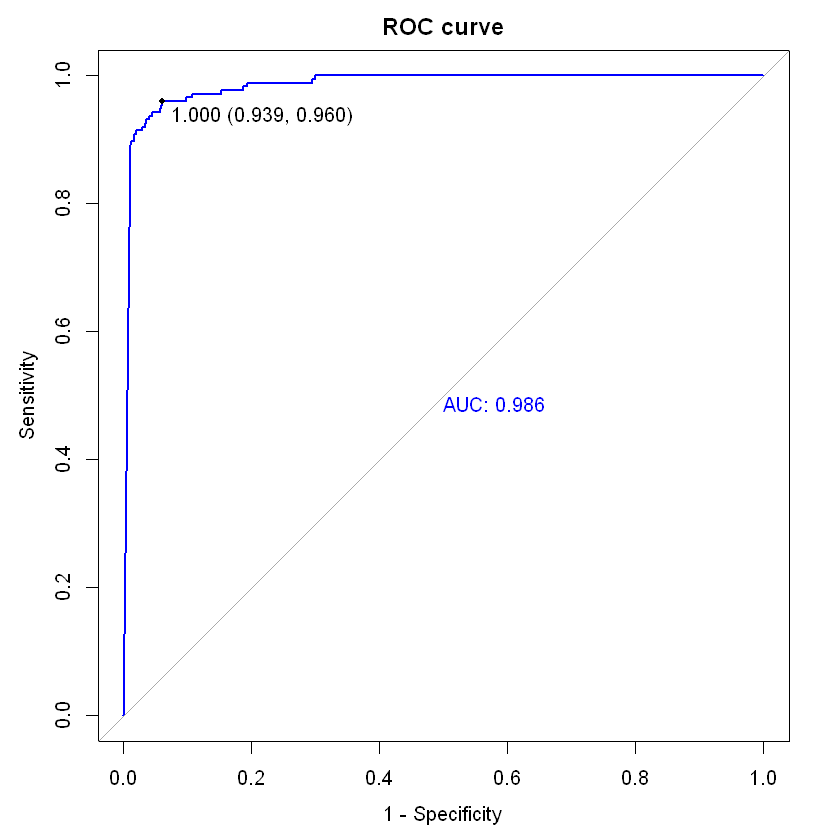

In [46]:
# Predicciones de probabilidad en el conjunto de prueba
nb_roc_prob <- predict(
  nb_roc,
  gytsNB_test[, colnames(gytsNB_test) != "CR7_bin"],
  type = "prob"
)
nb_roc_prob <- as.numeric(nb_roc_prob[, "X1"])

# Generación de la curva ROC
nb_roc_curve <- roc(gytsNB_test$CR7_bin, nb_roc_prob,
                    levels = c("X0", "X1"), direction = "<")
plot.roc(nb_roc_curve, main = "ROC curve", col = "blue", lwd = 2,
         legacy.axes = TRUE, print.thres = "best", print.auc = TRUE)

In [47]:
# Cálculo del punto de corte óptimo basado en la suma
# de sensibilidades y especificidades
aux <- nb_roc_curve$sensitivities + nb_roc_curve$specificities
corte <- nb_roc_curve$thresholds[which(aux == max(aux))]

# Convierto las probabilidades a clases binarias usando el punto de corte óptimo
nb_roc_class <- ifelse(nb_roc_prob < corte, "X0", "X1")
nb_roc_class <- factor(nb_roc_class, levels = c("X0", "X1"))

# Me aseguro de que `gytsNB_test$CR7_bin` tenga los mismos niveles
gytsNB_test$CR7_bin <- factor(gytsNB_test$CR7_bin, levels = c("X0", "X1"))

# Matriz de confusión y sensibilidad + especificidad
results <- confusionMatrix(nb_roc_class, gytsNB_test$CR7_bin)
print(results$table)

          Reference
Prediction  X0  X1
        X0 588   7
        X1  38 168


- La variable objetivo en este análisis es CR7_bin, que indica si un individuo mostró signos de ser fumador, es decir, si fumó al menos un día en los últimos 30 días (CR7_bin = 1), o si no fumó en absoluto (CR7_bin = 0). Todas las demás variables en el dataset se utilizaron como predictores para construir el modelo Naive Bayes.

- El modelo Naive Bayes fue entrenado y evaluado utilizando la métrica de ROC, lo que permitió medir la capacidad del modelo para discriminar entre los individuos que son fumadores y los que no lo son. La curva ROC obtenida mostró un AUC (Área Bajo la Curva) de 0.986, lo que indica un excelente rendimiento del modelo. Un AUC cercano a 1 implica que el modelo es capaz de distinguir casi perfectamente entre fumadores y no fumadores.

- El punto de corte óptimo fue seleccionado basándose en la maximización de la suma de sensibilidades y especificidades. Esto se hizo al calcular para cada posible umbral la suma de la sensibilidad (tasa de verdaderos positivos) y la especificidad (tasa de verdaderos negativos), y eligiendo el umbral que maximiza esta suma.

Punto de corte seleccionado: 0.939

- Este valor indica que cualquier probabilidad de que un individuo sea fumador superior a 0.939 se clasifica como 1 (fumador), y cualquier probabilidad igual o inferior se clasifica como 0 (no fumador). Este punto de corte fue elegido porque ofrece el mejor equilibrio entre la sensibilidad y la especificidad, lo que es crucial en contextos donde ambas medidas son importantes para una correcta clasificación.

La matriz de confusión generada a partir del modelo usando el punto de corte óptimo es la siguiente:

| Predicción / Realidad | No Fumador (0) | Fumador (1) |
|-----------------------|----------------|-------------|
| No Fumador (0)        | 588            | 7           |
| Fumador (1)           | 38             | 168         |

Interpretación de la Matriz de Confusión:

Verdaderos Negativos (588): El modelo clasificó correctamente a 588 individuos como no fumadores cuando realmente no lo eran.

Falsos Negativos (7): El modelo clasificó incorrectamente a 7 individuos como no fumadores cuando en realidad eran fumadores. Esto representa una pequeña cantidad de individuos fumadores que el modelo no pudo identificar.

Falsos Positivos (38): El modelo clasificó incorrectamente a 38 individuos como fumadores cuando en realidad no lo eran. Este número de falsos positivos es relevante para analizar, ya que en ciertos contextos, un alto número de falsos positivos podría ser problemático (por ejemplo, en intervenciones donde los recursos se destinan a aquellos clasificados como fumadores).

Verdaderos Positivos (168): El modelo identificó correctamente a 168 individuos como fumadores cuando realmente lo eran.

El modelo, con el punto de corte óptimo, ha logrado un buen equilibrio, reduciendo tanto los falsos negativos como los falsos positivos. Sin embargo, la decisión de qué umbral utilizar podría ajustarse dependiendo de la prioridad dada a la minimización de falsos negativos o falsos positivos en escenarios específicos.

Modelo de Regresión logistica

5.	**(Regresión lógistica)** Realice el tratamiento necesario a las variables que utilizará finalmente en función del algoritmo. Puede crear otras variables si lo desea. Explique.

1ero hay que recordar que ya se le han hecho en el código 3 cambios a la copia de la base de datos para el modelo de regresión logistica que son los siguientes:

Se Eliminaron las observaciones con valores faltantes en la variable CR7:
- `gytsRL <- gytsRL[!is.na(gytsRL$CR7), ]`

Se transformó CR7 en una variable binaria
- `gytsRL$CR7_bin <- ifelse(gytsRL$CR7 %in% 2:7, 1, 0)`

Se eliminó la variable CR7 dado que CR7_bin es una transformación de CR7 y no se necesita tener ambas variables:
- `gytsRL$CR7 <- NULL`

In [48]:
# Selecciono variables para la imputación
# (excluyendo FinalWgt, Stratum, PSU y CR7_bin)
vars_imput_RL <- names(gytsRL)[!names(gytsRL) %in%
                                     c("FinalWgt", "Stratum", "PSU", "CR7_bin")]

In [49]:
# Especifico el método de imputación
methods <- make.method(gytsRL)
# Uso 'pmm' para todas las variables a imputar
methods[vars_imput_RL] <- "pmm"

In [50]:
# Realizo la imputación MICE
# toma alrededor de 12 minutos
set.seed(12345)
imp <- mice(gytsRL[, vars_imput_RL], m = 5, maxit = 50,
            method = methods[vars_imput_RL], seed = 12345)


 iter imp variable
  1   1  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  CR14  OR9  CLR16  CLR17  ELR2  CR15  CR16  OR12  OR13  CR17  CR18  CR19  CR20  CLR27  CLR28  CR21  CR22  CR23  CR24  CLR33  CLR34  CR25  CLR36  CR27  CLR38  CLR39  CLR40  CLR41  CLR42  CR30  CR31  CR32  CLR46  CLR47  CLR48  CLR49  CR34  CR35  CR36  CR37  CR38  OR45  CR39  CR40  CR41  CR42  CR43  OR55  CLR62  CLR63  CLR64  CLR65  OR46  OR54  CLR68  CLR69  CLR70  CLR71  CLR72
  1   2  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  CR14  OR9  CLR16  CLR17  ELR2  CR15  CR16  OR12  OR13  CR17  CR18  CR19  CR20  CLR27  CLR28  CR21  CR22  CR23  CR24  CLR33  CLR34  CR25  CLR36  CR27  CLR38  CLR39  CLR40  CLR41  CLR42  CR30  CR31  CR32  CLR46  CLR47  CLR48  CLR49  CR34  CR35  CR36  CR37  CR38  OR45  CR39  CR40  CR41  CR42  CR43  OR55  CLR62  CLR63  CLR64  CLR65  OR46  OR54  CLR68  CLR69  CLR70  CLR71  CLR72
  1   3  CR1  CR2  CLR3  CLR4  CR5  CR6  CR8  CR9  CR10  CR11  CR12  CR13  C

In [51]:
# Extraigo el conjunto de datos imputado completo
gytsRL_imput <- complete(imp, 1)

# Añado las columnas que no se imputaron
gytsRL_imput$FinalWgt <- gytsRL$FinalWgt
gytsRL_imput$Stratum <- gytsRL$Stratum
gytsRL_imput$PSU <- gytsRL$PSU
gytsRL_imput$CR7_bin <- gytsRL$CR7_bin

# Verifico que no haya valores NA en el conjunto imputado
cat("Número de valores faltantes después de la imputación:\n")
print(colSums(is.na(gytsRL_imput)))

Número de valores faltantes después de la imputación:
     CR1      CR2     CLR3     CLR4      CR5      CR6      CR8      CR9 
       0        0        0        0        0        0        0        0 
    CR10     CR11     CR12     CR13     CR14      OR9    CLR16    CLR17 
       0        0        0        0        0        0        0        0 
    ELR2     CR15     CR16     OR12     OR13     CR17     CR18     CR19 
       0        0        0        0        0        0        0        0 
    CR20    CLR27    CLR28     CR21     CR22     CR23     CR24    CLR33 
       0        0        0        0        0        0        0        0 
   CLR34     CR25    CLR36     CR27    CLR38    CLR39    CLR40    CLR41 
       0        0        0        0        0        0        0        0 
   CLR42     CR30     CR31     CR32    CLR46    CLR47    CLR48    CLR49 
       0        0        0        0        0        0        0        0 
    CR34     CR35     CR36     CR37     CR38     OR45     CR39     CR4

In [53]:
# Aplico la función de creación de dummies ya creada en Naive Bayes
# Considerando la variable "cols_categoricas" ya creada en NB
gytsRL_imput <- crear_dummies(gytsRL_imput, cols_categoricas)

In [54]:
# Verifico que no haya valores NA después de crear dummies
print(colSums(is.na(gytsRL_imput)))

         FinalWgt               PSU           CR7_bin Stratum_201604001 
                0                 0                 0                 0 
Stratum_201604002 Stratum_201604003 Stratum_201604004 Stratum_201604005 
                0                 0                 0                 0 
Stratum_201604006 Stratum_201604007 Stratum_201604008 Stratum_201604009 
                0                 0                 0                 0 
Stratum_201604010 Stratum_201604011             CR1_1             CR1_2 
                0                 0                 0                 0 
            CR1_3             CR1_4             CR1_5             CR1_6 
                0                 0                 0                 0 
            CR2_1            CLR3_1            CLR3_2            CLR3_3 
                0                 0                 0                 0 
           CLR3_4            CLR3_5            CLR4_1            CLR4_2 
                0                 0                

In [55]:
# Muestro las dimensiones del nuevo dataframe
print(dim(gytsRL_imput))

[1] 2668  238


In [56]:
# Muestro los nombres de las columnas
print(names(gytsRL_imput))

  [1] "FinalWgt"          "PSU"               "CR7_bin"          
  [4] "Stratum_201604001" "Stratum_201604002" "Stratum_201604003"
  [7] "Stratum_201604004" "Stratum_201604005" "Stratum_201604006"
 [10] "Stratum_201604007" "Stratum_201604008" "Stratum_201604009"
 [13] "Stratum_201604010" "Stratum_201604011" "CR1_1"            
 [16] "CR1_2"             "CR1_3"             "CR1_4"            
 [19] "CR1_5"             "CR1_6"             "CR2_1"            
 [22] "CLR3_1"            "CLR3_2"            "CLR3_3"           
 [25] "CLR3_4"            "CLR3_5"            "CLR4_1"           
 [28] "CLR4_2"            "CLR4_3"            "CLR4_4"           
 [31] "CLR4_5"            "CLR4_6"            "CR5_1"            
 [34] "CR6_1"             "CR6_2"             "CR6_3"            
 [37] "CR6_4"             "CR6_5"             "CR6_6"            
 [40] "CR8_1"             "CR8_2"             "CR8_3"            
 [43] "CR8_4"             "CR8_5"             "CR8_6"            
 [46] "CR9

In [57]:
#procedo a eliminar las columnas que no aportan información
# PSU y FinalWgt
gytsRL_imput$PSU <- NULL
gytsRL_imput$FinalWgt <- NULL

In [58]:
# Convierto la variable objetivo en factor
gytsRL_imput$CR7_bin <- as.factor(gytsRL_imput$CR7_bin)

# Convierto todas las variables dummy a factores
gytsRL_imput <- gytsRL_imput %>%
  mutate(across(where(is.integer), as.factor))

# Verificación final de la estructura del dataset
str(gytsRL_imput)

'data.frame':	2668 obs. of  236 variables:
 $ CR7_bin          : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604001: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Stratum_201604002: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604003: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604004: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604005: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604006: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604007: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604008: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604009: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604010: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Stratum_201604011: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ CR1_1            : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1

6. **(Regresion logistica)** Inserte una semilla. Divida la base de datos en los conjuntos de entrenamiento y prueba. Verifique que la variable objetivo cumpla el supuesto de proporción en cada conjunto.

In [59]:
# Inserto semilla para reproducibilidad
set.seed(12345)

# División del conjunto de datos en entrenamiento (70%) y prueba (30%)
split <- initial_split(gytsRL_imput, prop = 0.7, strata = "CR7_bin")
gytsRL_train <- training(split)
gytsRL_test <- testing(split)

In [60]:
# Verificación de la proporción de la variable objetivo en los conjuntos
cat("Proporción de la variable objetivo en el conjunto de entrenamiento:\n")
print(round(prop.table(table(gytsRL_train$CR7_bin)), 2))

cat("Proporción de la variable objetivo en el conjunto de prueba:\n")
print(round(prop.table(table(gytsRL_test$CR7_bin)), 2))

Proporción de la variable objetivo en el conjunto de entrenamiento:

   0    1 
0.78 0.22 
Proporción de la variable objetivo en el conjunto de prueba:

   0    1 
0.78 0.22 


7. **(Regresion logistica)** Prediga la variable objetivo del conjunto de prueba y muestre los resultados de la curva ROC. Reporte cuál es el punto de corte que seleccionó para transformar las probabilidades estimadas en clases estimadas y fundamente. Muestre la matriz de confusión final e interprete.

In [61]:
# Ajusto el modelo
set.seed(12345)
model_rl <- glm(CR7_bin ~ ., data = gytsRL_train,
                family = binomial(), control = list(maxit = 50))

In [62]:
# Realizo la predicción de probabilidades en el conjunto de prueba
prob_pred_rl <- predict(model_rl, gytsRL_test, type = "response")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



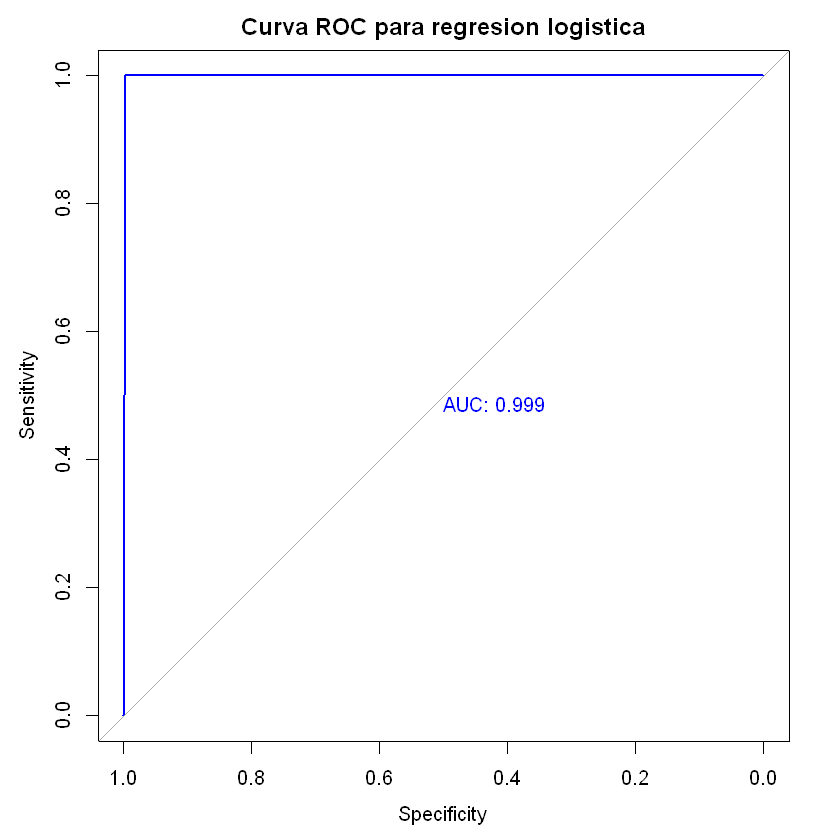

In [63]:
# Generación de la curva ROC
roc_rl <- roc(gytsRL_test$CR7_bin, prob_pred_rl)
plot.roc(roc_rl, main = "Curva ROC para regresion logistica",
         col = "blue", lwd = 2, print.auc = TRUE)

In [64]:
# Determino el punto de corte óptimo
corte_opt <- coords(roc_rl, "best", ret = "threshold", transpose = TRUE)

# Me aseguro de que sea un valor numérico
corte_opt <- as.numeric(corte_opt)

# Imprimo el punto de corte óptimo
cat("Punto de corte óptimo:", corte_opt, "\n")

Punto de corte óptimo: 0.5 


In [65]:
# Conversión de probabilidades a clases utilizando el punto de corte óptimo
pred_class_rl <- ifelse(prob_pred_rl > corte_opt, 1, 0)
pred_class_rl <- factor(pred_class_rl, levels = c(0, 1))

In [66]:
# genero matriz de confusión
conf_matrix_rl <- confusionMatrix(pred_class_rl, gytsRL_test$CR7_bin)
print(conf_matrix_rl$table)

          Reference
Prediction   0   1
         0 625   0
         1   1 175


Interpretación de la Matriz de Confusión:

- Verdaderos Negativos (TN): 625 (casos que son 0 y fueron predichos como 0).
- Falsos Negativos (FN): 0 (casos que son 1 pero fueron predichos como 0).
- Verdaderos Positivos (TP): 175 (casos que son 1 y fueron predichos como 1).
- Falsos Positivos (FP): 1 (casos que son 0 pero fueron predichos como 1).

- Perfecta Sensibilidad (FN = 0): Tener 0 falsos negativos significa que el modelo no cometió errores al identificar los casos positivos (los 1). Esto podría sugerir que el modelo está sobreajustado, especialmente si la variable objetivo está desbalanceada (muchos más 0 que 1).

- Casi Perfecta Especificidad (FP = 1): Tener solo 1 falso positivo es bastante inusual y sugiere que el modelo está funcionando excepcionalmente bien o que el conjunto de datos tiene un fuerte sesgo que facilita la predicción (por ejemplo, si los predictores tienen una relación muy fuerte con la variable objetivo).

Umbral de Corte (Threshold) en 0.5:

El hecho de que el umbral óptimo haya sido 0.5 es común en muchos problemas de clasificación, pero en algunos casos, podría ser un indicador de que el modelo no está considerando un balance adecuado entre sensibilidad y especificidad.

Posible Sobreajuste

Perfecta Separación: Los resultados que muestran un casi perfecto ajuste (solo un error) pueden indicar que el modelo está sobreajustado a los datos de entrenamiento, especialmente si el conjunto de datos es pequeño o si hay demasiadas variables predictoras. Esto puede resultar en un modelo que no generaliza bien a nuevos datos.

- AUC Alto: Un AUC de 0.999 significa que el modelo tiene una capacidad casi perfecta para distinguir entre las clases positivas y negativas. En teoría, esto es excelente, pero en la práctica, un valor tan alto puede indicar que el modelo está sobreajustado (overfitting)

- Sesgo de Datos: Otro posible problema podría ser que los datos están sesgados o que hay una fuerte correlación entre las variables predictoras y la variable objetivo, lo que hace que el modelo parezca casi perfecto en el conjunto de datos actual, pero posiblemente no se desempeñe tan bien en un conjunto de datos diferente.

Tras analizar el problema de clasificación del hábito de fumar en jóvenes, utilizando Regresión Logística y Naive Bayes, se concluye que ambos algoritmos son altamente efectivos para predecir si un individuo es fumador o no.

Comparación de desempeño:

| Modelo               | AUC   | Precisión | Sensibilidad | Especificidad | Punto de Corte |
|----------------------|-------|-----------|--------------|---------------|----------------|
| Regresión Logística  | 0.999 | 0.998     | 1.0          | 0.998         | 0.5            |
| Naive Bayes          | 0.986 | 0.917     | 0.823        | 0.960         | 0.939          |


Análisis Regresión Logística:

Ventajas:

Alcanzó una precisión casi perfecta (0.998) en el conjunto de prueba, clasificando correctamente casi todas las instancias.

Obtuvo un AUC de 0.999, lo que indica una capacidad de discriminación excepcional.

La matriz de confusión muestra un solo falso positivo y ningún falso negativo, lo que indica una alta capacidad para identificar correctamente tanto a fumadores como a no fumadores.


Desventajas:

La precisión casi perfecta, con tan pocos errores, genera preocupación por un posible sobreajuste a los datos de entrenamiento.


Análisis Naive Bayes:

Ventajas:

Mostró una excelente capacidad de discriminación con un AUC de 0.986 en la curva ROC.

Logró un buen equilibrio entre sensibilidad (0.823) y especificidad (0.960) con un punto de corte optimizado de 0.939.

Desventajas:

Presentó un mayor número de errores de clasificación en comparación con la regresión logística, con 7 falsos negativos y 38 falsos positivos.

Conclusión Final y Comparación de Modelos

Comparación y Elección del Mejor Modelo:

**ROC y AUC**: Aunque ambos modelos tienen un AUC alto, el modelo de regresión logística muestra un AUC ligeramente superior. Sin embargo, el modelo de Naive Bayes podría ser más robusto, ya que no mostró indicios significativos de sobreajuste en el conjunto de prueba.

**Punto de Corte y Matriz de Confusión**: El modelo de Naive Bayes parece manejar mejor el equilibrio entre la sensibilidad y especificidad con un punto de corte más alto. La matriz de confusión sugiere que Naive Bayes tiene un mejor desempeño práctico en la clasificación correcta de fumadores y no fumadores, aunque con un pequeño sacrificio en sensibilidad.

Decisión:

Si la principal métrica de interés es el AUC, elegiría la regresión logística como el mejor modelo. Sin embargo, existe la preocupación del sobreajuste y por ende, si se desea un modelo más robusto con una buena generalización, Naive Bayes es entonces la opción que yo preferiría.